[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cohen's Kappa between Vader Sentiment and TextBlob Sentiment: 0.26
Cohen's Kappa between Vader Sentiment and Afinn Sentiment: 0.66
Cohen's Kappa between Vader Sentiment and SentiWordNet Sentiment: 0.10
Cohen's Kappa between TextBlob Sentiment and Afinn Sentiment: 0.21
Cohen's Kappa between TextBlob Sentiment and SentiWordNet Sentiment: 0.19
Cohen's Kappa between Afinn Sentiment and SentiWordNet Sentiment: 0.08


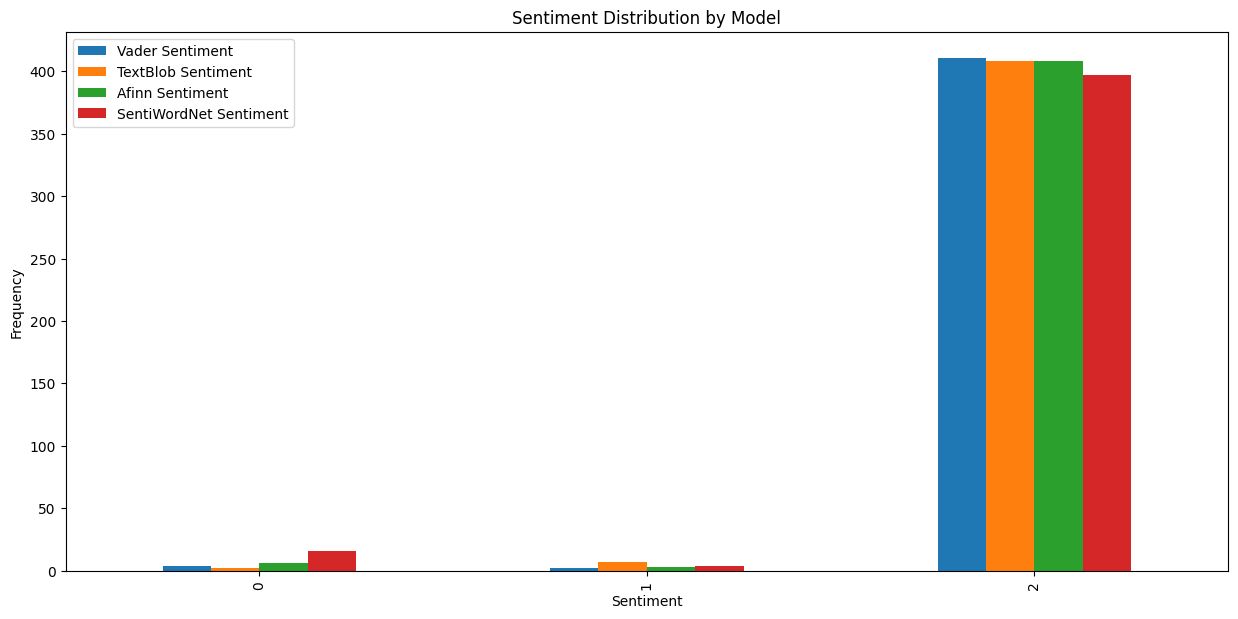

Saved final DataFrame with sentiments to Baby_Product_Review_Sentiment_Analysis.csv


<ipython-input-22-4979ad1f3fc1>:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Sentiment Category'] = final_df['Aggregated Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})


In [22]:
import pandas as pd
import numpy as np
import re
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
from nltk.corpus import sentiwordnet as swn, stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import cohen_kappa_score

# Download required NLTK data
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

class SentimentAnalyzer:
    def __init__(self):
        # Initialize sentiment analysis tools and preprocessors
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.afinn_analyzer = Afinn()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Preprocess text by lowering case, removing punctuation, numbers, and stopwords, and lemmatizing."""
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        words = nltk.word_tokenize(text)  # Tokenize
        words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]  # Lemmatize and remove stopwords
        return ' '.join(words)

    def analyze_vader(self, text):
        """Analyze sentiment using VADER."""
        scores = self.vader_analyzer.polarity_scores(text)['compound']
        if scores > 0.05:
            return 'positive'
        elif scores < -0.05:
            return 'negative'
        else:
            return 'neutral'

    def analyze_textblob(self, text):
        """Analyze sentiment using TextBlob."""
        sentiment = TextBlob(text).sentiment.polarity
        if sentiment > 0.05:
            return 'positive'
        elif sentiment < -0.05:
            return 'negative'
        else:
            return 'neutral'

    def analyze_afinn(self, text):
        """Analyze sentiment using Afinn."""
        sentiment = self.afinn_analyzer.score(text)
        if sentiment > 0:
            return 'positive'
        elif sentiment < 0:
            return 'negative'
        else:
            return 'neutral'

    def analyze_sentiwordnet(self, text):
        """Analyze sentiment using SentiWordNet."""
        words = nltk.word_tokenize(text)
        pos_score = 0
        neg_score = 0
        for word in words:
            synsets = list(swn.senti_synsets(word))
            if synsets:
                pos_score += synsets[0].pos_score()
                neg_score += synsets[0].neg_score()
        if pos_score > neg_score:
            return 'positive'
        elif pos_score < neg_score:
            return 'negative'
        else:
            return 'neutral'

def generate_word_cloud(words, sentiment, filename):
    """Generate and save a word cloud image for the given sentiment category."""
    try:
        word_freq = Counter(words)
        unique_words = list(set(word_freq.keys()))  # Ensure words are unique
        if unique_words:  # Only generate word cloud if there are words
            text = ' '.join(unique_words)
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud for {sentiment} Influential Words')
            plt.savefig(filename, format='jpeg', dpi=300)  # Save as JPEG with high resolution
            plt.close()
        else:
            print(f"No words to generate word cloud for sentiment: {sentiment}")
    except Exception as e:
        print(f"Error generating word cloud for {sentiment}: {e}")

def extract_influential_words(df, sentiment_column, sentiment_label):
    """Extract influential words for the given sentiment label."""
    words = []
    for text, sentiment in zip(df['Cleaned Text'], df[sentiment_column]):
        if sentiment == sentiment_label:
            words.extend(nltk.word_tokenize(text.lower()))
    return words

def compare_sentiment_models(df):
    """Compare sentiment models using Cohen's Kappa score and save the plot."""
    try:
        models = ['Vader Sentiment', 'TextBlob Sentiment', 'Afinn Sentiment', 'SentiWordNet Sentiment']
        kappa_scores = []

        # Calculate pairwise agreement
        for i in range(len(models)):
            for j in range(i + 1, len(models)):
                model1 = models[i]
                model2 = models[j]
                agreement = cohen_kappa_score(df[model1], df[model2])
                kappa_scores.append((model1, model2, agreement))
                print(f'Cohen\'s Kappa between {model1} and {model2}: {agreement:.2f}')

        # Create a DataFrame for visualization
        kappa_df = pd.DataFrame(kappa_scores, columns=['Model 1', 'Model 2', 'Cohen\'s Kappa'])

        # Plot Cohen's Kappa scores
        plt.figure(figsize=(12, 6))
        for _, row in kappa_df.iterrows():
            plt.bar(f'{row["Model 1"]} vs {row["Model 2"]}', row['Cohen\'s Kappa'], color='skyblue')

        plt.title('Cohen\'s Kappa Score Between Different Sentiment Models')
        plt.xlabel('Model Pair')
        plt.ylabel('Cohen\'s Kappa')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/cohens_kappa_comparison.jpeg', format='jpeg', dpi=300)  # Save as JPEG on Google Drive
        plt.close()

        # Visualize sentiment distribution
        df[models].apply(pd.Series.value_counts).plot(kind='bar', figsize=(15, 7))
        plt.title('Sentiment Distribution by Model')
        plt.xlabel('Sentiment')
        plt.ylabel('Frequency')
        plt.legend(models)
        plt.show()

    except Exception as e:
        print(f"Error comparing sentiment models: {e}")

def run_non_transformer_models(file_path):
    """Main function to run sentiment analysis models, generate word clouds, and compare models."""
    try:
        df = pd.read_csv(file_path)  # Load dataset
        analyzer = SentimentAnalyzer()
        df['Cleaned Text'] = df['Review Content'].apply(analyzer.preprocess_text)

        # Apply sentiment analysis models
        df['Vader Sentiment'] = df['Cleaned Text'].apply(analyzer.analyze_vader)
        df['TextBlob Sentiment'] = df['Cleaned Text'].apply(analyzer.analyze_textblob)
        df['Afinn Sentiment'] = df['Cleaned Text'].apply(analyzer.analyze_afinn)
        df['SentiWordNet Sentiment'] = df['Cleaned Text'].apply(analyzer.analyze_sentiwordnet)

        # Aggregate results based on majority vote
        df['Aggregated Sentiment'] = df[['Vader Sentiment', 'TextBlob Sentiment', 'Afinn Sentiment', 'SentiWordNet Sentiment']].mode(axis=1)[0]

        # Convert sentiments to numeric labels
        sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
        for column in ['Vader Sentiment', 'TextBlob Sentiment', 'Afinn Sentiment', 'SentiWordNet Sentiment']:
            df[column] = df[column].map(sentiment_mapping)
        df['Aggregated Sentiment'] = df['Aggregated Sentiment'].map(sentiment_mapping)

        # Extract and generate word clouds for influential words
        for sentiment, label in sentiment_mapping.items():
            words = extract_influential_words(df, 'Aggregated Sentiment', label)
            generate_word_cloud(words, sentiment.capitalize(), f'/content/drive/MyDrive/wordcloud_{sentiment}.jpeg')  # Save as JPEG on Google Drive

        # Compare sentiment models
        compare_sentiment_models(df)

        # Final DataFrame with necessary columns
        final_df = df[['Review Date', 'Reviewer Name', 'Review Title', 'Review Content', 'Aggregated Sentiment']]
        final_df['Sentiment Category'] = final_df['Aggregated Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
        final_df.to_csv('/content/drive/MyDrive/Baby_Product_Review_Sentiment_Analysis.csv', index=False)
        print("Saved final DataFrame with sentiments to Baby_Product_Review_Sentiment_Analysis.csv")

    except Exception as e:
        print(f"Error running non-transformer models: {e}")

if __name__ == '__main__':
    run_non_transformer_models('/content/drive/MyDrive/reviews_ref.csv')  # Replace with your actual file path on Google Drive